In [104]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
# Read in all 5 years record then combine to one dataset
df = pd.DataFrame()

for i in range(1,6):
    path = '../Data/' + str(i) + 'year.arff'
    data = arff.loadarff(path)
    data = pd.DataFrame(data[0])
    df = pd.concat([df, data], ignore_index=True, sort=False)

df.shape

(43405, 65)

In [106]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [107]:
# There are 2 classes: 0 and 1 - dtype is int!
print(df.groupby(['class'])['class'].count())

class
b'0'    41314
b'1'     2091
Name: class, dtype: int64


In [108]:
# Map class to 0 and 1
class_dict = {b'0': '0', b'1': '1'}

df['class'] = df['class'].map(class_dict)
print(df.groupby(['class'])['class'].count())

class
0    41314
1     2091
Name: class, dtype: int64


## EDA

### Missing Values

In [109]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing
Attr37,18984,0.437369
Attr21,5854,0.134869
Attr27,2764,0.063679
Attr60,2152,0.049580
Attr45,2147,0.049464
...,...,...
Attr35,8,0.000184
Attr1,8,0.000184
Attr57,7,0.000161
Attr59,7,0.000161


In [110]:
df_na.shape

(64, 2)

Text(0.5, 1.0, 'Correlation Heatmap')

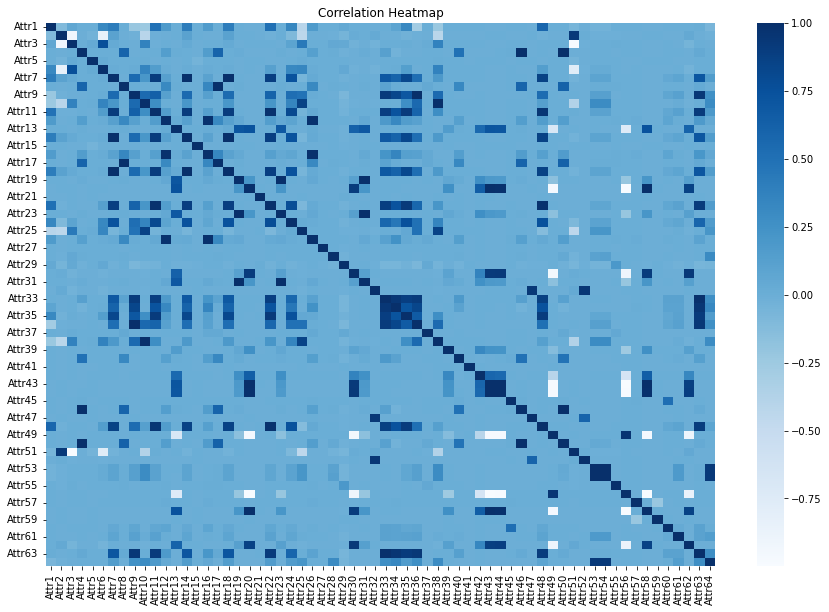

In [111]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), cmap="Blues")
plt.title("Correlation Heatmap")

Random forest in Python are going to require that your complete that your data set is complete.

However, extra boost and gbm will have the ability to use different types of techniques to handle missing values.

- Use StratifiedShuffleSplit to keep the unbalance weight in both train and test dataset.
- Split 20% for test dataset.

In [112]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_valid_index in split.split(df, df['class']):
    train = df.iloc[train_index]
    test = df.iloc[test_valid_index]

print("Size of modeling set (to be CV split): ", train.shape)
print(train.groupby(['class'])['class'].count())
print(train['class'].value_counts(normalize=True))
print("Size of hold back validation set: ", test.shape)
print(test.groupby(['class'])['class'].count())
print(test['class'].value_counts(normalize=True))

Size of modeling set (to be CV split):  (39064, 65)
class
0    37182
1     1882
Name: class, dtype: int64
0    0.951823
1    0.048177
Name: class, dtype: float64
Size of hold back validation set:  (4341, 65)
class
0    4132
1     209
Name: class, dtype: int64
0    0.951854
1    0.048146
Name: class, dtype: float64


In [113]:
X_train = train.drop(['class'],axis=1).values #droping target
Y_train = train['class'].values
Y_train = Y_train.astype(int)

X_test = test.drop(['class'],axis=1).values #droping target
Y_test = test['class'].values
Y_test = Y_test.astype(int)

In [92]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label = Y_train)
D_test = xgb.DMatrix(X_test, label = Y_test)

In [150]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

param = {
    'eta': 1, 
    'max_depth': 50,
    'min_child_weight': 2,
    'objective': 'multi:softprob',  'num_class': 2}
    #'multi:softprob',  
    #'num_class': 2} 

steps = 20

model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

print(classification_report(Y_test, best_preds))

Precision = 0.9136322545961327
Recall = 0.7797555084137343
Accuracy = 0.9741994932043307
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4132
           1       0.85      0.56      0.68       209

    accuracy                           0.97      4341
   macro avg       0.91      0.78      0.83      4341
weighted avg       0.97      0.97      0.97      4341



**scale_pos_weight [default=1]** - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

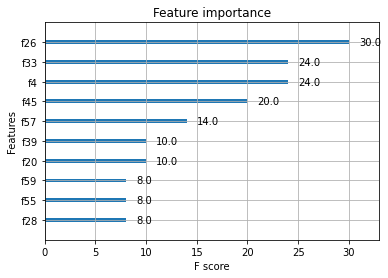

In [120]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10)

**scale_pos_weight** [default=1] - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). 

In [116]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import time

cv_object = StratifiedKFold(n_splits=num_cv_iterations, shuffle=True, random_state=27)

xgb_clf = XGBClassifier(use_label_encoder=False)

num_searches = 10

params = {
        'n_estimators':[500,1000],
        'eta':[0.001, 0.01,0.1],
        'max_depth':[5,15,20],
        'max_leaves': [30,50,70],
        'min_child_weight': [5, 10, 15],
        'gamma': [1, 1.5, 2, 2.5],
        'subsample': [0.6, 0.8, 1.0],
        'scale_pos_weight': [1,10,20,30]
        }

fit_params = {
'early_stopping_rounds': 5,
'eval_metric': 'logloss',
'eval_set': [[X_train, Y_train]]
}


rs_clf = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=num_searches, scoring='accuracy', n_jobs=6, cv=cv_object, verbose=3, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, Y_train, **fit_params)
print("Randomized search time:", time.time() - search_time_start)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [127]:
from sklearn.metrics import confusion_matrix

def plot_confusion(cf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in
    zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # x_axis_labels = ['<30', '>30']
    # y_axis_labels = ['<30', '>30']
    ax = plt.axes()
    # sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('   Bankruptcy Prediction Confusion Matrix\n')
    plt.xlabel("Predicted Bankruptcy")
    plt.ylabel("True Bankruptcy") 

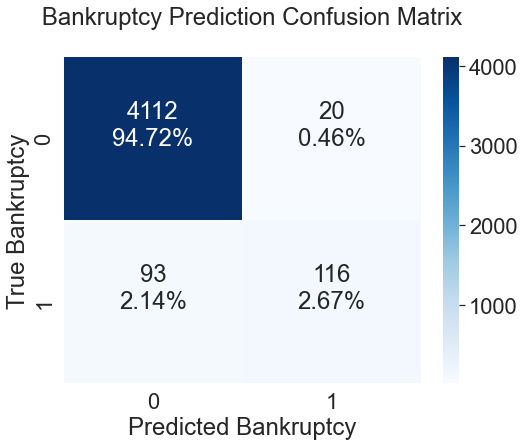

In [143]:
lr_cm = confusion_matrix(Y_test, best_preds)
plot_confusion(lr_cm)